In [1]:
import librosa
import librosa.display
import numpy as np

In [2]:
CNN_INPUT_SIZE = (128, 20)
DEFAULT_SR = 22050

In [3]:
def resize_axis(array, N):
    if(array.shape[1] > N):
        resized = array[:,:N]
    else:
        resized = np.lib.pad(array, ((0,0),(0,N - array.shape[1])),\
            'constant', constant_values=(np.min(array)))
    return resized

In [4]:
def extract_cnn_input(raw_audio):
    frame_length = min(2048, len(raw_audio))
    mel_spec = librosa.core.power_to_db(librosa.feature.melspectrogram(
        y=raw_audio, sr=DEFAULT_SR, n_fft=frame_length,
        hop_length=frame_length//4, n_mels=CNN_INPUT_SIZE[0])
    )
    # Truncate number of frames stored
    m = min(CNN_INPUT_SIZE[1], mel_spec.shape[1])
    N =20
    mell = resize_axis(mel_spec[:, 0:m], N)
    return mell

---

In [5]:
import os

def onehot(str):
    path = './Drum'
    kits = os.listdir(path)
    #kits.remove('.DS_Store')
    
    oh = []

    for kit in kits:
        if str == kit:
            oh.append(1)
        else:
            oh.append(0)
    
    return np.array(oh)

In [6]:
#path = 'Drum\Snare\9th Snare 38.wav'

y_label = None
x_label = None

drumkit_path = './Drum'
kits = os.listdir(drumkit_path)

for kit in kits:
    path = os.path.join(drumkit_path, kit)
    sounds = os.listdir(path)
    
    for sound in sounds:
        wavfile = os.path.join(path, sound)
        y, sr = librosa.load(wavfile)
        yt, index = librosa.effects.trim(y=y, top_db=30)
        yt = librosa.util.normalize(yt)
        k = extract_cnn_input(yt)
        k = np.expand_dims(k, axis=0)
        
        typ = onehot(kit)
        typ = np.expand_dims(typ, axis=0)
        
        if x_label is None:
            x_label = k.copy()
            y_label = typ.copy()
        else:
            x_label = np.concatenate((x_label, k), axis=0)
            y_label = np.concatenate((y_label, typ), axis=0)
        
        

/Users/cooky/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


In [7]:
#Shuffle Data

shuffle = np.arange(y_label.shape[0])
np.random.shuffle(shuffle)

x_label = x_label[shuffle]
y_label = y_label[shuffle]

In [8]:
y_label

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_label, y_label, test_size=0.2)

In [10]:
x_train.shape

(560, 128, 20)

In [11]:
y_train

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [12]:
# change y_label to fit sci-kit specification (one-hot to categorical #)

yy_test = np.array([])
for i in range(x_test.shape[0]):
    imsi = np.array([])
    count = 0
    for j in range(7):
        if int(y_test[i,j]) == 0:
            count += 1
        else:
            yy_test = np.concatenate((yy_test, np.array([count])), axis=0)
            break


In [13]:
yy_train = np.array([])
for i in range(x_train.shape[0]):
    imsi = np.array([])
    count = 0
    for j in range(7):
        if int(y_train[i,j]) == 0:
            count += 1
        else:
            yy_train = np.concatenate((yy_train, np.array([count])), axis=0)
            break



---

In [14]:
y_train.shape

(560, 7)

In [15]:
x_train.shape

(560, 128, 20)

In [16]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models



In [17]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 20,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-20 19:50:19.375496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-20 19:50:19.375787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
 1/14 [=>............................] - ETA: 5s - loss: 0.0192 - accuracy: 1.0000

2022-05-20 19:53:06.310947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 41ms/step - loss: 0.0225 - accuracy: 0.9911 - val_loss: 0.1064 - val_accuracy: 0.9554
Epoch 2/20


2022-05-20 19:53:06.819499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 24ms/step - loss: 0.0122 - accuracy: 0.9955 - val_loss: 0.0665 - val_accuracy: 0.9643
Epoch 3/20
14/14 [==============================] - 0s 26ms/step - loss: 0.0139 - accuracy: 0.9978 - val_loss: 0.0369 - val_accuracy: 0.9911
Epoch 4/20
14/14 [==============================] - 0s 34ms/step - loss: 0.0315 - accuracy: 0.9888 - val_loss: 0.1456 - val_accuracy: 0.9732
Epoch 5/20
14/14 [==============================] - 0s 28ms/step - loss: 0.0687 - accuracy: 0.9844 - val_loss: 0.0381 - val_accuracy: 0.9821
Epoch 6/20
14/14 [==============================] - 0s 23ms/step - loss: 0.0128 - accuracy: 0.9933 - val_loss: 0.0814 - val_accuracy: 0.9643
Epoch 7/20
14/14 [==============================] - 0s 36ms/step - loss: 0.0131 - accuracy: 0.9978 - val_loss: 0.0622 - val_accuracy: 0.9911
Epoch 8/20
14/14 [==============================] - 0s 23ms/step - loss: 0.0112 - accuracy: 0.9955 - val_loss: 0.0347 - val_accuracy: 0.9821
Epoch 9/20
14/14 [======

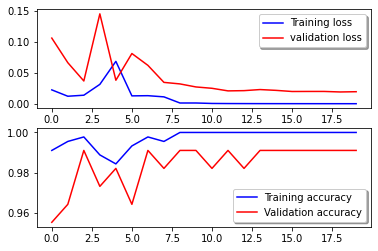

In [28]:
import matplotlib.pyplot as plt

# Plot the loss and accurac curves for training and validation

fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
ax[0].plot(history.history['val_loss'], color='r', label = "validation loss", axes = ax[0])
legend = ax[0].legend(loc='best', shadow = True)

ax[1].plot(history.history['accuracy'], color = 'b', label = "Training accuracy")
ax[1].plot(history.history['val_accuracy'], color = 'r', label = "Validation accuracy")
legend = ax[1].legend(loc = 'best', shadow = True)

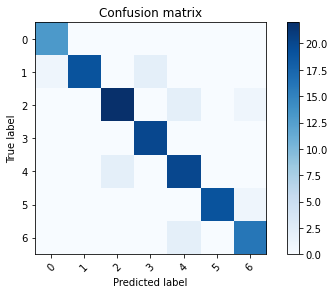

In [32]:
from sklearn.metrics import confusion_matrix

# Look at confusion matrix


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    #thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #	plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_tru = np.argmax(y_test, axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_tru, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

In [35]:
Y_pred

array([[9.67784858e-22, 2.72294674e-20, 4.74871340e-16, 1.05874321e-16,
        9.45715395e-10, 1.64438518e-27, 1.00000000e+00],
       [9.99484599e-01, 1.44500746e-07, 5.55942722e-11, 5.15192864e-04,
        1.18036695e-07, 1.20768000e-08, 9.68238645e-09],
       [3.88344953e-17, 1.04630118e-13, 9.99999523e-01, 8.16901007e-17,
        4.23882824e-07, 2.31324915e-08, 1.47615652e-11],
       [1.25503811e-06, 1.69609102e-05, 2.89530471e-05, 5.08283584e-08,
        1.05827157e-05, 9.99942303e-01, 7.05096606e-11],
       [5.50522041e-12, 3.52484967e-05, 7.82806260e-18, 9.99946713e-01,
        6.55663328e-08, 1.12379659e-12, 1.78964656e-05],
       [1.36140246e-08, 1.82327700e-08, 1.14881949e-11, 1.74970823e-12,
        3.03534115e-10, 1.00000000e+00, 2.02039828e-13],
       [8.96054286e-10, 5.07466869e-09, 9.97929096e-01, 5.93469662e-10,
        1.34486705e-03, 7.26020487e-04, 1.75593229e-08],
       [1.84859289e-13, 7.42670465e-19, 4.28164417e-22, 9.99999881e-01,
        7.88761838e-08, 7

<AxesSubplot:>

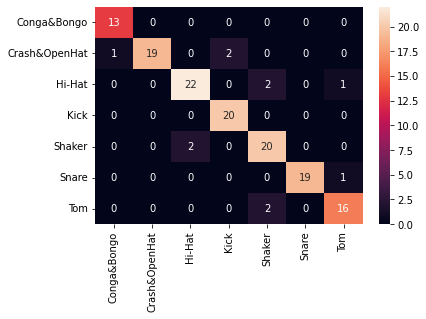

In [36]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

classes = ['Conga&Bongo', 'Crash&OpenHat', 'Hi-Hat', 'Kick', 'Shaker', 'Snare', 'Tom']

cm = pd.DataFrame(confusion_matrix(Y_tru, Y_pred_classes), columns=classes, index=classes)
sns.heatmap(cm, annot=True)

In [21]:
model.evaluate(x_test, y_test)

1/5 [=====>........................] - ETA: 1s - loss: 0.3026 - accuracy: 0.8438

2022-05-20 19:51:24.028986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 135ms/step - loss: 0.2785 - accuracy: 0.9214


[0.27846866846084595, 0.9214285612106323]

In [22]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [124]:
predict = probability_model.predict(x_test)

In [129]:
np.argmax(predict[0])

3

In [130]:
yy_test[0]

3.0

In [135]:
tf.math.confusion_matrix(
    labels=yy_test,
    predictions=predict
)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [140] != values[1].shape = [140,7] [Op:Pack] name: stack